In [1]:
##%matplotlib widget
%matplotlib notebook

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Tue May 21 10:17:01 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.40.04    Driver Version: 418.40.04    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   37C    P8    24W / 250W |      0MiB / 12036MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

### Set up local parameters

In [5]:
n_epochs = 20

# Name is the output file name
##oldName = 'Oct11_SimpleCNN4Layer_C_100epochs_160K_lr_3em4'
##oldName = 'Oct22_SimpleCNN5Layer_C_many_epochs_160K_lr_1em4_bs64'
##oldName = 'Oct22_SimpleCNN5Layer_C_restart40epochs_240K_lr_1em4_bs64'
##oldName = 'Oct28_SimpleCNN4Layer_D_YetAnother400epochs_240K_lr_1em3_bs64'
##oldName = 'Nov11_SimpleCNN4Layer_D35_Amother200epochs_240K_lr_3em5_bs64'
##oldName = 'Nov14_SimpleCNN4Layer_D25_Another50epochs_240K_lr_3em5_bs64'
##oldName = 'Nov15_SimpleCNN4Layer_D25_Another50epochs_240K_lr_1em4_bs64_Alt_Loss_A_0p5'
##oldName = 'Nov15_SimpleCNN4Layer_D35_YetAnother50epochs_240K_lr_1em4_bs64_Alt_Loss_A_1p0'
##oldName = 'Nov15_SimpleCNN4Layer_D35_YetAnother50epochs_240K_lr_1em4_bs64_Alt_Loss_A_1p5'
##oldName = 'Nov15_SimpleCNN4Layer_D35_YetAnother20epochs_240K_lr_1em4_bs64_Alt_Loss_A_2p0'
##oldName = 'Nov15_SimpleCNN4Layer_D35_YetAnother250epochs_240K_lr_3em5_bs64_Alt_Loss_A_2p5'
oldName = 'Nov15_SimpleCNN4Layer_D35_YetAnother150epochs_240K_lr_1em4_bs64_Alt_Loss_A_3p0'
name = 'May14_SimpleCNN4Layer_D35_20epochs_240K_lr_1em4_bs64_Alt_Loss_A_3p0'


# Make an output folder named "name" (change if you want)
output = Path(name)
oldOutput = Path(oldName)
# These are the input data files to read in
trainfile = [Path('/share/lazy/schreihf/PvFinder/Aug14_80K_train.npz'),
            Path('/share/lazy/schreihf/PvFinder/Oct03_80K_train.npz'),
            Path('/share/lazy/schreihf/PvFinder/Oct03_80K2_train.npz')]
valfile = Path('/share/lazy/schreihf/PvFinder/Oct03_20K_val.npz')

# Size of batches
batch_size = 64

# How fast to learn
learning_rate = 1e-4

Make the output directory if it does not exist:

In [6]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [7]:
# From model/collectdata.py
from model.collectdata import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu

# From model/models.py
from model.models_mds_C import SimpleCNN4Layer_D35 as Model

from model.training import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [8]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [9]:
device = select_gpu(2)

1 available GPUs (initially using device 0):
  0 TITAN V


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [10]:
## newer vernacular
# Training dataset. You can put as many files here as desired.
train_loader = collect_data('data/Aug14_80K_train.h5',
                            'data/Oct03_80K_train.h5',
                            'data/Oct03_80K2_train.h5',
                            batch_size=batch_size,
                            device=device,
                            masking=True, shuffle=True)

# Validation dataset. You can slice to reduce the size.
val_loader = collect_data('data/Oct03_20K_val.h5',
                          batch_size=batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False)

Loading data...
Loaded data/Aug14_80K_train.h5 in 11.88 s
Loaded data/Oct03_80K_train.h5 in 11.33 s
Loaded data/Oct03_80K2_train.h5 in 11.27 s
Constructing 240000 event dataset took 9.144 s
Loading data...
Loaded data/Oct03_20K_val.h5 in 2.812 s
Constructing 9984 event dataset took 0.4152 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [11]:
model = Model()
loss = Loss(epsilon=1e-5,coefficient=3.0)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [13]:
print('output = ',output)
print('oldOutput = ',oldOutput)
##model.load_state_dict(torch.load('./Nov15_SimpleCNN4Layer_D35_YetAnother150epochs_240K_lr_1em4_bs64_Alt_Loss_A_3p0/Nov15_SimpleCNN4Layer_D35_YetAnother150epochs_240K_lr_1em4_bs64_Alt_Loss_A_3p0_final.pyt'))

output =  May14_SimpleCNN4Layer_D35_20epochs_240K_lr_1em4_bs64_Alt_Loss_A_3p0
oldOutput =  Nov15_SimpleCNN4Layer_D35_YetAnother150epochs_240K_lr_1em4_bs64_Alt_Loss_A_3p0


In [14]:
model = model.to(device)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


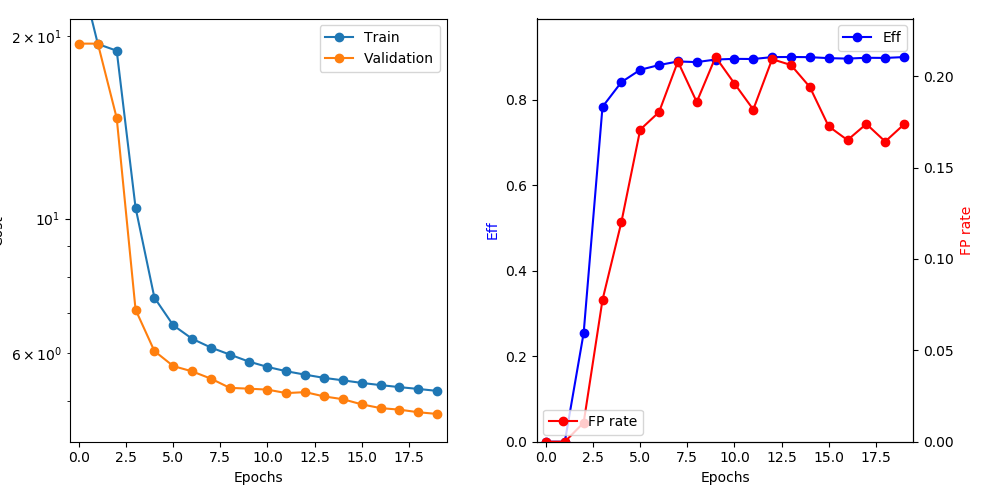

In [15]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [16]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 3750, val = 156


Epoch 0: train=25.8994, val=19.4176, took 77.185 s
  Validation Found 0 of 54700, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 1: train=19.3894, val=19.4176, took 75.014 s
  Validation Found 0 of 54700, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 2: train=18.9023, val=14.6423, took 73.878 s
  Validation Found 13917 of 54700, added 104 (eff 25.44%) (0.0104 FP/event)


Epoch 3: train=10.4255, val=7.07976, took 73.316 s
  Validation Found 42853 of 54700, added 775 (eff 78.34%) (0.0776 FP/event)


Epoch 4: train=7.40937, val=6.05059, took 74.026 s
  Validation Found 46003 of 54700, added 1199 (eff 84.10%) (0.12 FP/event)


Epoch 5: train=6.67195, val=5.71578, took 73.721 s
  Validation Found 47589 of 54700, added 1705 (eff 87.00%) (0.171 FP/event)


Epoch 6: train=6.33974, val=5.60201, took 73.42 s
  Validation Found 48193 of 54700, added 1801 (eff 88.10%) (0.18 FP/event)


Epoch 7: train=6.13089, val=5.44898, took 73.449 s
  Validation Found 48656 of 54700, added 2077 (eff 88.95%) (0.208 FP/event)


Epoch 8: train=5.97068, val=5.26246, took 73.476 s
  Validation Found 48572 of 54700, added 1856 (eff 88.80%) (0.186 FP/event)


Epoch 9: train=5.81538, val=5.24621, took 73.866 s
  Validation Found 48900 of 54700, added 2102 (eff 89.40%) (0.211 FP/event)


Epoch 10: train=5.69705, val=5.22705, took 74.08 s
  Validation Found 48988 of 54700, added 1957 (eff 89.56%) (0.196 FP/event)


Epoch 11: train=5.60451, val=5.1585, took 73.937 s
  Validation Found 48967 of 54700, added 1815 (eff 89.52%) (0.182 FP/event)


Epoch 12: train=5.5321, val=5.17781, took 74.072 s
  Validation Found 49212 of 54700, added 2090 (eff 89.97%) (0.209 FP/event)


Epoch 13: train=5.46547, val=5.09433, took 73.769 s
  Validation Found 49228 of 54700, added 2058 (eff 90.00%) (0.206 FP/event)


Epoch 14: train=5.41475, val=5.04025, took 72.965 s
  Validation Found 49204 of 54700, added 1938 (eff 89.95%) (0.194 FP/event)


Epoch 15: train=5.36151, val=4.94323, took 72.976 s
  Validation Found 49078 of 54700, added 1723 (eff 89.72%) (0.173 FP/event)


Epoch 16: train=5.31741, val=4.87316, took 72.996 s
  Validation Found 49021 of 54700, added 1648 (eff 89.62%) (0.165 FP/event)


Epoch 17: train=5.27694, val=4.84474, took 72.884 s
  Validation Found 49126 of 54700, added 1736 (eff 89.81%) (0.174 FP/event)


Epoch 18: train=5.24047, val=4.79748, took 72.978 s
  Validation Found 49104 of 54700, added 1640 (eff 89.77%) (0.164 FP/event)


Epoch 19: train=5.20179, val=4.76646, took 73.072 s
  Validation Found 49217 of 54700, added 1734 (eff 89.98%) (0.174 FP/event)



# Results

Let's save some results: (even though if you have not changed the code above, it saves the model every epoch)

Go ahead and save the final model (even though it was also saved above):

In [ ]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [ ]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

In [ ]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [ ]:
quit()